# Extracting Reaction Networks from RHEA

This notebook shows how to extract edges connecting RHEA reactions based on shared non-currency metabolites. The resulting network can be used to analyze the connectivity of RHEA reactions.

 

In [121]:
# TAXID = "9606" # Hs
TAXID = "7227" # Dmel

OUTDIR = f"output/{TAXID}"


In [122]:
# use python to mkdir
import os
os.makedirs(OUTDIR, exist_ok=True)

In [123]:
from functools import lru_cache
from collections import defaultdict

import pandas as pd
from semsql.sqla.semsql import Statements

from oaklib import get_adapter
from oaklib.interfaces.association_provider_interface import AssociationProviderInterface
from tests import CATALYTIC_ACTIVITY

In [124]:


adapter = get_adapter("sqlite:obo:rhea")
pd.DataFrame(adapter.ontology_metadata_map(list(adapter.ontologies())[0]))

id                                dcterms:description  \
0  obo:rhea.owl  Rhea is an expert-curated knowledgebase of che...   

  dcterms:license                           dcterms:title  \
0       CC-BY-4.0  Rhea, the Annotated Reactions Database   

  oio:auto-generated-by oio:hasOBOFormatVersion         owl:versionIRI  \
0          bio2obo:rhea                     1.2  obo:rhea/135/rhea.owl   

       rdf:type sh:prefix                               schema:url  \
0  owl:Ontology       obo  http://purl.obolibrary.org/obo/rhea.owl   

                         rdfs:isDefinedBy  
0  http://purl.obolibrary.org/obo/obo.owl

## Quad Mapping

RHEA models reactions as "quads", for all combinations of L/R directionality. GO uses the non-directional "top" form.
The biopragmatics ontology places directional relationships on directed reactions only. We create a mapping table
to convert RHEA reactions from their left-to-right form to the canonical form.

In [125]:
session = adapter.session

In [126]:
CANONICAL_TO_LR = "obo:debio_0000007"
q = session.query(Statements).filter(Statements.predicate == CANONICAL_TO_LR)

In [127]:
lr_to_canonical = {row.object: row.subject for row in q}
len(lr_to_canonical)

16970

In [128]:
assert lr_to_canonical["RHEA:10001"] == "RHEA:10000"

In [129]:
labels = {k: v for k, v in adapter.labels(adapter.entities())}

In [130]:
len([l for id, l in labels.items() if " = " in str(l)])

16970

## Create a DataFrame of Reaction Edges

In [131]:
chebi_adapter = get_adapter("sqlite:obo:chebi")

In [132]:
HAS_INPUT = "RO:0002233"
HAS_OUTPUT = "RO:0002234"


In [133]:
import pandas as pd

def rels_to_df(rels) -> pd.DataFrame:
    objs = []
    for r in rels:
        if r[0] not in lr_to_canonical:
            continue
        reaction = lr_to_canonical[r[0]]
        reaction_label = labels[reaction]
        #if " => " not in reaction_label:
        #    continue
        objs.append(
            {"reaction": reaction, "reaction_label": reaction_label, "predicate": r[1], "chemical": r[2]}
        )
    return pd.DataFrame(objs)
    #return pd.DataFrame([{"reaction": r[0], "reaction_label": labels[r[0]], "chemical": r[2], "predicate": r[1]} for r in rels if " => " in str(labels[r[0]])])

In [134]:
input_edges = rels_to_df(adapter.relationships(predicates=[HAS_INPUT]))
input_edges

reaction                                     reaction_label  \
0      RHEA:10000            H2O + pentanamide = NH4(+) + pentanoate   
1      RHEA:10000            H2O + pentanamide = NH4(+) + pentanoate   
2      RHEA:10004         benzyl isothiocyanate = benzyl thiocyanate   
3      RHEA:10008  [protein]-dithiol + a hydroperoxide = [protein...   
4      RHEA:10008  [protein]-dithiol + a hydroperoxide = [protein...   
...           ...                                                ...   
38144  RHEA:80727  a di-trans,poly-cis-dolichal + NADP(+) = a di-...   
38145  RHEA:80731  a di-trans,poly-cis-dolichol + NADP(+) = a di-...   
38146  RHEA:80731  a di-trans,poly-cis-dolichol + NADP(+) = a di-...   
38147  RHEA:80735  a di-trans,poly-cis-dolichol + NAD(+) = a di-t...   
38148  RHEA:80735  a di-trans,poly-cis-dolichol + NAD(+) = a di-t...   

        predicate     chemical  
0      RO:0002233  CHEBI:15377  
1      RO:0002233  CHEBI:16459  
2      RO:0002233  CHEBI:17484  
3      RO:0002233  CHEBI:29950  
4      RO:0002233  CHEBI:35924  
...           ...          ...  
38144  RO:0002233  CHEBI:58349  
38145  RO:0002233  CHEBI:16091  
38146  RO:0002233  CHEBI:58349  
38147  RO:0002233  CHEBI:16091  
38148  RO:0002233  CHEBI:57540  

[38149 rows x 4 columns]

In [135]:
output_edges = rels_to_df(adapter.relationships(predicates=[HAS_OUTPUT]))
output_edges

reaction                                     reaction_label  \
0      RHEA:10000            H2O + pentanamide = NH4(+) + pentanoate   
1      RHEA:10000            H2O + pentanamide = NH4(+) + pentanoate   
2      RHEA:10004         benzyl isothiocyanate = benzyl thiocyanate   
3      RHEA:10008  [protein]-dithiol + a hydroperoxide = [protein...   
4      RHEA:10008  [protein]-dithiol + a hydroperoxide = [protein...   
...           ...                                                ...   
44212  RHEA:80731  a di-trans,poly-cis-dolichol + NADP(+) = a di-...   
44213  RHEA:80731  a di-trans,poly-cis-dolichol + NADP(+) = a di-...   
44214  RHEA:80735  a di-trans,poly-cis-dolichol + NAD(+) = a di-t...   
44215  RHEA:80735  a di-trans,poly-cis-dolichol + NAD(+) = a di-t...   
44216  RHEA:80735  a di-trans,poly-cis-dolichol + NAD(+) = a di-t...   

        predicate      chemical  
0      RO:0002234   CHEBI:28938  
1      RO:0002234   CHEBI:31011  
2      RO:0002234   CHEBI:16017  
3      RO:0002234   CHEBI:15377  
4      RO:0002234   CHEBI:30879  
...           ...           ...  
44212  RO:0002234  CHEBI:231637  
44213  RO:0002234   CHEBI:57783  
44214  RO:0002234   CHEBI:15378  
44215  RO:0002234  CHEBI:231637  
44216  RO:0002234   CHEBI:57945  

[44217 rows x 4 columns]

In [136]:
all_edges = pd.concat([input_edges, output_edges])
all_edges

reaction                                     reaction_label  \
0      RHEA:10000            H2O + pentanamide = NH4(+) + pentanoate   
1      RHEA:10000            H2O + pentanamide = NH4(+) + pentanoate   
2      RHEA:10004         benzyl isothiocyanate = benzyl thiocyanate   
3      RHEA:10008  [protein]-dithiol + a hydroperoxide = [protein...   
4      RHEA:10008  [protein]-dithiol + a hydroperoxide = [protein...   
...           ...                                                ...   
44212  RHEA:80731  a di-trans,poly-cis-dolichol + NADP(+) = a di-...   
44213  RHEA:80731  a di-trans,poly-cis-dolichol + NADP(+) = a di-...   
44214  RHEA:80735  a di-trans,poly-cis-dolichol + NAD(+) = a di-t...   
44215  RHEA:80735  a di-trans,poly-cis-dolichol + NAD(+) = a di-t...   
44216  RHEA:80735  a di-trans,poly-cis-dolichol + NAD(+) = a di-t...   

        predicate      chemical  
0      RO:0002233   CHEBI:15377  
1      RO:0002233   CHEBI:16459  
2      RO:0002233   CHEBI:17484  
3      RO:0002233   CHEBI:29950  
4      RO:0002233   CHEBI:35924  
...           ...           ...  
44212  RO:0002234  CHEBI:231637  
44213  RO:0002234   CHEBI:57783  
44214  RO:0002234   CHEBI:15378  
44215  RO:0002234  CHEBI:231637  
44216  RO:0002234   CHEBI:57945  

[82366 rows x 4 columns]

In [137]:
chebi_counts = all_edges["chemical"].value_counts().reset_index()
chebi_counts.columns = ["chemical", "count"]
chebi_counts

chemical  count
0      CHEBI:15378   9754
1      CHEBI:15377   6205
2      CHEBI:15379   2709
3      CHEBI:57287   1505
4      CHEBI:30616   1288
...            ...    ...
13043  CHEBI:68560      1
13044  CHEBI:17194      1
13045  CHEBI:85278      1
13046  CHEBI:57948      1
13047  CHEBI:62497      1

[13048 rows x 2 columns]

In [138]:
chebi_counts['chemical_label'] = chebi_counts['chemical'].apply(lambda x: chebi_adapter.label(x))
chebi_counts

chemical  count                                     chemical_label
0      CHEBI:15378   9754                                             hydron
1      CHEBI:15377   6205                                              water
2      CHEBI:15379   2709                                           dioxygen
3      CHEBI:57287   1505                                     coenzyme A(4-)
4      CHEBI:30616   1288                                            ATP(4-)
...            ...    ...                                                ...
13043  CHEBI:68560      1  UDP-N-acetyl-6-(alpha-D-galactose-1-phosphonat...
13044  CHEBI:17194      1                                 bromochloromethane
13045  CHEBI:85278      1                      17beta-hydroxyandrostan-3-one
13046  CHEBI:57948      1                                  5-oxo-D-prolinate
13047  CHEBI:62497      1     7-(3-methylbut-2-enyl)-L-tryptophan zwitterion

[13048 rows x 3 columns]

In [139]:
#adapter.label("CHEBI:15378")

## Find currency chemicals

In [140]:
chebi_counts[chebi_counts["count"] > 100]

chemical  count                                   chemical_label
0    CHEBI:15378   9754                                           hydron
1    CHEBI:15377   6205                                            water
2    CHEBI:15379   2709                                         dioxygen
3    CHEBI:57287   1505                                   coenzyme A(4-)
4    CHEBI:30616   1288                                          ATP(4-)
5    CHEBI:58349   1285                                         NADP(3-)
6    CHEBI:57783   1279                                        NADPH(4-)
7    CHEBI:57540   1196                                          NAD(1-)
8    CHEBI:33019   1130                                  diphosphate(3-)
9    CHEBI:57945   1116                                         NADH(2-)
10   CHEBI:43474   1016                                hydrogenphosphate
11   CHEBI:16526    998                                   carbon dioxide
12   CHEBI:59789    866               S-adenosyl-L-methionine zwitterion
13  CHEBI:456216    856                                          ADP(3-)
14   CHEBI:58210    809                                          FMN(3-)
15   CHEBI:57618    794                                        FMNH2(2-)
16   CHEBI:57856    793             S-adenosyl-L-homocysteine zwitterion
17   CHEBI:58223    580                                          UDP(3-)
18   CHEBI:28938    530                                         ammonium
19  CHEBI:456215    521                   adenosine 5'-monophosphate(2-)
20   CHEBI:29101    514                                       sodium(1+)
21   CHEBI:16240    450                                hydrogen peroxide
22   CHEBI:16810    447                               2-oxoglutarate(2-)
23   CHEBI:17499    414                                   hydrogen donor
24   CHEBI:13193    414                                hydrogen acceptor
25   CHEBI:57288    354                                   acetyl-CoA(4-)
26   CHEBI:30031    347                                    succinate(2-)
27   CHEBI:29033    268                                         iron(2+)
28   CHEBI:29985    262                                  L-glutamate(1-)
29   CHEBI:29034    253                                         iron(3+)
30   CHEBI:33737    238                         di-mu-sulfido-diiron(2+)
31   CHEBI:33738    238                         di-mu-sulfido-diiron(1+)
32   CHEBI:58885    234                          UDP-alpha-D-glucose(2-)
33   CHEBI:15361    218                                         pyruvate
34   CHEBI:57384    211                                  malonyl-CoA(5-)
35   CHEBI:17996    205                                         chloride
36   CHEBI:64479    190  O-(pantetheine-4'-phosphoryl)serine(1-) residue
37   CHEBI:58189    187                                          GDP(3-)
38   CHEBI:30089    177                                          acetate
39   CHEBI:57692    176                                          FAD(3-)
40  CHEBI:175763    175         2-trans,6-trans-farnesyl diphosphate(3-)
41   CHEBI:60377    168                    cytidine 5'-monophosphate(2-)
42   CHEBI:58307    161                                        FADH2(2-)
43   CHEBI:57305    151                               glycine zwitterion
44   CHEBI:58343    146             adenosine 3',5'-bismonophosphate(4-)
45   CHEBI:16842    141                                     formaldehyde
46   CHEBI:29950    139                               L-cysteine residue
47   CHEBI:29969    137                               L-lysinium residue
48   CHEBI:57844    134                          L-methionine zwitterion
49   CHEBI:57972    133                             L-alanine zwitterion
50   CHEBI:28868    132                                 fatty acid anion
51    CHEBI:4167    120                                  D-glucopyranose
52   CHEBI:57925    119                                glutathionate(1-)
53   CHEBI:16189    118                                          s

## Ranking Edges

In [141]:
def annotate_edges_with_rank(df: pd.DataFrame) -> pd.DataFrame:
    """
    Annotate edges with a rank based on the count of the chemical, grouped by reaction.
    
    :param df: 
    :return: 
    """
    df = df.merge(chebi_counts, left_on="chemical", right_on="chemical")
    df["rank"] = df.groupby("reaction")["count"].rank()
    return df

In [142]:
input_edges = annotate_edges_with_rank(input_edges)
output_edges = annotate_edges_with_rank(output_edges)


In [143]:
all_edges = pd.concat([input_edges, output_edges])

In [144]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from io import BytesIO
import base64


def basic_plot(G, title=None, filename=None):
    if title is None:
        title = G.graph.get("title", "Process (undetermined)")
    plt.figure(figsize=(36, 24))
    pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=50)
    
    node_colors = []
    node_sizes = []
    outer_nodes = []
    outer_colors = []
    outer_sizes = []
    
    base_size = 1000
    border_width = 2000  # Width of the outer circle
    
    for node in G.nodes():
        # Set color based on node type
        if G.nodes[node].get('type') == 'chemical':
            node_colors.append('yellow')
        else:
            node_colors.append('green')
            
        if G.nodes[node].get('role') in [INPUT, OUTPUT, INTERMEDIATE]:
            node_sizes.append(base_size * 2)  # Double size for input/output nodes
            # Add node to the outer circle list
            outer_nodes.append(node)
            outer_colors.append('black')  # Color of the border
            outer_sizes.append((base_size * 2) + border_width)  # Slightly larger for border effect

        else:
            node_sizes.append(base_size)
            
    # Draw outer circles first (only for input/output nodes)
    if outer_nodes:
        nx.draw_networkx_nodes(G, pos,
                             nodelist=outer_nodes,
                             node_size=outer_sizes,
                             node_color=outer_colors,
                             alpha=0.3)
            
    # Draw the graph elements separately
    nx.draw_networkx_nodes(G, pos,
                          node_size=node_sizes,
                          node_color=node_colors,
                          alpha=0.6)
    
    nx.draw_networkx_edges(G, pos,
                          width=0.1,
                          edge_color='gray')
     # Add node labels
    node_labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos,
                            labels=node_labels,
                            font_size=24)  # Adjust font size as needed
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos,
                                edge_labels=edge_labels,
                                font_size=18) 
    nx.draw(G, pos,
           node_size=50,        
           node_color='blue',
           alpha=0.6,          # Transparency
           width=5,          
           edge_color='gray')
    plt.title(title, fontsize=24)
    # Save plot to a temporary buffer
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    if filename:
        plt.savefig(f"output/{filename}.png", format='png', bbox_inches='tight')
    plt.close()
    
    # Encode the image
    data = base64.b64encode(buf.getvalue()).decode('utf-8')
    
    # Create HTML with scrollable container
    html = f'''
        <div style="width: 100%; overflow-x: auto; overflow-y: auto; max-height: 800px;">
            <img src="data:image/png;base64,{data}" style="width: auto; height: auto;">
        </div>
    '''
    
    return HTML(html)

#basic_plot(g)

## GO Annotations

In [145]:
go_adapter = get_adapter("sqlite:obo:go")

In [146]:
amigo_adapter: AssociationProviderInterface = get_adapter(f"amigo:NCBITaxon:{TAXID}")

from oaklib.interfaces.association_provider_interface import AssociationProviderInterface

if not isinstance(amigo_adapter, AssociationProviderInterface):
    raise ValueError


In [147]:
HAS_PRIMARY_INPUT = "RO:0004009"
HAS_PRIMARY_OUTPUT = "RO:0004008"
HAS_INTERMEDIATE = "RO:0002505"

In [148]:
INPUT = "input"
OUTPUT = "output"
INTERMEDIATE = "intermediate"
rlabels = {
    HAS_PRIMARY_INPUT: INPUT,
    HAS_PRIMARY_OUTPUT: OUTPUT,
    HAS_INTERMEDIATE: INTERMEDIATE,
}

In [149]:
BIOSYNTHESIS = "GO:0009058"
CATABOLISM = "GO:0009056"

In [150]:
GLUT_BIOSYN = "GO:0006750"
ISOP_VIA_MEV = "GO:1902767"

In [151]:
from oaklib.datamodels.vocabulary import IS_A, PART_OF


def create_go_participant_df(parent) -> pd.DataFrame:
    parent_label = go_adapter.label(parent)
    if not parent_label:
        return pd.DataFrame()
    subs = list(go_adapter.descendants([parent], predicates=[IS_A]))
    print(len(subs), "subs of ", parent)
    go_map = defaultdict(dict)
    completed_preds = set()
    while HAS_PRIMARY_INPUT not in completed_preds and HAS_PRIMARY_OUTPUT not in completed_preds:
        if not subs:
            break
        for s, p, o in go_adapter.relationships(subjects=subs, predicates=[HAS_PRIMARY_INPUT, HAS_PRIMARY_OUTPUT, HAS_INTERMEDIATE], include_abox=False):
            pred_name = rlabels.get(p, p)
            go_map[s][pred_name] = o
            completed_preds.add(p)
        next_parent = subs.pop()
        if not next_parent:
            break
        subs.extend([o for _s, _p, o in go_adapter.relationships([next_parent], predicates=[IS_A])])
        
    return pd.DataFrame([{"go": k, INPUT: v.get(INPUT), OUTPUT: v.get(OUTPUT), INTERMEDIATE: v.get(INTERMEDIATE)} for k, v in go_map.items()])
    


In [152]:
create_go_participant_df(GLUT_BIOSYN)

1 subs of  GO:0006750


go input       output intermediate
0  GO:0006750  None  CHEBI:57925         None

In [153]:
create_go_participant_df("GO:1902767")


2 subs of  GO:1902767


go input       output intermediate
0  GO:1902767  None         None  CHEBI:25350
1  GO:0008299  None  CHEBI:24913         None

In [154]:
assert create_go_participant_df("FAKE_GO_ID").empty

In [155]:
def query_genes(go_id, evidence_codes = None, pred=None) -> pd.DataFrame:
    """
    Query AmiGO for genes associated with a GO term.
    
    :param go_id: 
    :param evidence_codes: 
    :param pred: 
    :return: 
    """
    assocs = amigo_adapter.associations(objects=[go_id], object_closure_predicates=[IS_A, PART_OF])
    objs = []
    for assoc in assocs:
        if evidence_codes and assoc.evidence_type not in evidence_codes:
            continue
        objs.append({"gene": assoc.subject,
                     "gene_label": assoc.subject_label,
                     "evidence": assoc.evidence_type,
                     "term": assoc.object})
    return pd.DataFrame(objs)
        

In [156]:
gb_df = query_genes(GLUT_BIOSYN)
gb_df

gene gene_label evidence        term
0   FB:FBgn0046114       Gclm      IDA  GO:0006750
1   FB:FBgn0046114       Gclm      IDA  GO:0006750
2   FB:FBgn0046114       Gclm      IMP  GO:0006750
3   FB:FBgn0046114       Gclm      IEA  GO:0006750
4   FB:FBgn0046114       Gclm      IBA  GO:0006750
5   FB:FBgn0000566        Cth      IMP  GO:0006750
6   FB:FBgn0030882       Gss1      IEA  GO:0004363
7   FB:FBgn0030882       Gss1      IEA  GO:0006750
8   FB:FBgn0030882       Gss1      IBA  GO:0004363
9   FB:FBgn0040319       Gclc      IGI  GO:0006750
10  FB:FBgn0040319       Gclc      ISS  GO:0006750
11  FB:FBgn0040319       Gclc      IDA  GO:0006750
12  FB:FBgn0040319       Gclc      IEA  GO:0006750
13  FB:FBgn0040319       Gclc      IBA  GO:0006750
14  FB:FBgn0052495       Gss2      IEA  GO:0004363
15  FB:FBgn0052495       Gss2      IEA  GO:0004363
16  FB:FBgn0052495       Gss2      IEA  GO:0004363
17  FB:FBgn0052495       Gss2      IEA  GO:0004363
18  FB:FBgn0052495       Gss2      IEA  GO:0006750
19  FB:FBgn0052495       Gss2      IEA  GO:0006750
20  FB:FBgn0052495       Gss2      IEA  GO:0006750

In [157]:
assert query_genes("FAKE_GO_ID").empty

In [158]:
CATALYTIC_ACTIVITY = "GO:0003824"


@lru_cache
def make_annotons(process: str, max_genes=20, taxid=TAXID) -> pd.DataFrame:
    """
    Create a DataFrame of annotons for a given process.
    
    :param process: ID for GO BP
    :return: 
    """
    participant_df = create_go_participant_df(process)
    #values = unique_values_dict(participant_df, ["input", "output"])
    if len(participant_df) == 0:
        return pd.DataFrame()
    process_primary_input = participant_df["input"].unique().tolist()
    process_primary_output = participant_df["output"].unique().tolist()
    gene_df = query_genes(process)
    if len(gene_df) == 0:
        return pd.DataFrame()
    gene_ids = list(gene_df["gene"].unique())
    if len(gene_ids) > max_genes:
        print(f"Too many genes {len(gene_ids)}")
        return pd.DataFrame()
    
    # find all genes for a process
    print(f"Genes {len(gene_ids)}")
    assocs = amigo_adapter.associations(subjects=gene_ids, objects=[CATALYTIC_ACTIVITY], object_closure_predicates=[IS_A, PART_OF], limit=-1)
    
    # for each gene, find the associated catalytic activities
    objs = []
    for assoc in assocs:
        gene = assoc.subject
        # print(assoc)
        process_evidence = tuple(sorted(gene_df[gene_df["gene"] == gene]["evidence"].values))
        mf = assoc.object
        mappings = list(go_adapter.sssom_mappings(assoc.object, source="RHEA"))
        # print(f"Looking up {mf} => {len(mappings)}")
        for m in mappings:
            r = m.object_id
            objs.append({"gene": gene,
                         "gene_label": assoc.subject_label,
                         "process": process, 
                         "process_evidence": process_evidence,
                         "activity": mf, 
                         "activity_evidence": assoc.evidence_type, 
                         "primary_input": process_primary_input,
                         "primary_output": process_primary_output,
                         "reaction": r,
                         "reaction_label": labels.get(r)})
    return pd.DataFrame(objs)


assert len(make_annotons("GO:0046854")) == 0

5 subs of  GO:0046854
Too many genes 27


In [159]:
assert len(make_annotons("FAKE_PROCESS")) == 0

In [160]:
df = make_annotons(GLUT_BIOSYN)
if TAXID == "9606":
    assert len(df) > 30
else:
    assert len(df) > 4

1 subs of  GO:0006750
Genes 5


In [161]:
example_annoton_df = df

In [162]:
def create_bipartite_graph(annoton_df: pd.DataFrame, max_chem_occurrence=300) -> nx.Graph:
    """
    Create a bipartite graph of chemicals and reactions from an annoton DataFrame.
    
    :param annoton_df: 
    :param max_chem_occurrence: 
    :return: 
    """
    genes_by_reaction = defaultdict(set)
    reactions = annoton_df["reaction"].unique().tolist()
    g = nx.Graph()
    # source and sink CHEBI nodes
    process_ids = annoton_df["process"].unique().tolist()
    target_chemicals = set()
    chebi_to_direction = {}
    
    reaction_chemicals = set()
    for _, row in annoton_df.iterrows():
        # for each MF annotation, map RHEA to CHEBI + direction,
        # and create edges between RHEA and CHEBI
        r = row["reaction"]
        genes_by_reaction[r].add((row["gene"], row["gene_label"], row["process_evidence"]))
        for _, ch_row in all_edges[all_edges["reaction"] == r].iterrows():
            if ch_row["count"] > max_chem_occurrence and ch_row["rank"] > 1:
                # skip high-occurrence chemicals
                continue
            chemical = ch_row["chemical"]
            pred = "left" if ch_row["predicate"] == HAS_INPUT else "right"
            if not chemical in g:
                g.add_node(chemical, label=chebi_adapter.label(chemical), type="chemical")
                reaction_chemicals.add(chemical)
            g.add_edge(r, chemical, label=pred)
            
    for r, genes in genes_by_reaction.items():
        # label each reaction node based on genes/complexes that enable it,
        # plus the evidence codes for the gene being associated to the process
        def ev_tuples_to_compact(ev: set):
            ev_compact = set()
            for code in ev:
                if code == "IBA":
                    ev_compact.add("A")
                elif code in ["IEA", "ISS", "ISO"]:
                    ev_compact.add("C")
                else:
                    ev_compact.add("E")
            return "".join(sorted(list(ev_compact)))
        gene_lbl = "\n".join([f"{lbl} {ev_tuples_to_compact(ev)}" for _, lbl, ev in genes])
        g.add_node(r, label=f"{r}\n{gene_lbl}", type="reaction")
        
    for p in process_ids:
        # for each process ID (should be exactly one for leaf nodes, but may include subsumers),
        # ensure that the "target" chemical is in the graph and is labeled.
        chebi_df = create_go_participant_df(p)
        for k in [INPUT, OUTPUT, INTERMEDIATE]:
            # check BP to CHEBI for each role
            chebis = chebi_df[k].unique().tolist()
            # print(f"CHEBIs {k} {chebis} for {p}")
            for chebi in chebis:
                if not chebi:
                    continue
                chebi_to_direction[chebi] = k
                target_chemicals.add(chebi)
                if chebi in g:
                    # already in graph; set the role
                    g.nodes[chebi]["role"] = k
                else:
                    # not in the graph; add it
                    g.add_node(chebi, label=f"{chebi} {chebi_adapter.label(chebi)}", type="chemical", role=k)
                    # check for case where the target chemical is there as subsumer or subsumed.
                    for existing_chemical in reaction_chemicals:
                        if chebi in set(chebi_adapter.ancestors([existing_chemical], predicates=[IS_A])):
                            g.add_edge(existing_chemical, chebi, label=f"is_a")
                        else:
                            if existing_chemical in set(chebi_adapter.ancestors([chebi], predicates=[IS_A])):
                                g.add_edge(chebi, existing_chemical, label=f"is_a")

    ccs = list(nx.connected_components(g))
    
    g.graph.update(
        {
            "title": ", ".join([str(go_adapter.label(p)) for p in process_ids]),
            "number_of_connected_components": len(ccs),
            "longest_path": max([len(cc) for cc in ccs]),
            "number_of_reactions": len(reactions),
            "number_of_chemicals": len(reaction_chemicals),
            "target_chemicals": target_chemicals,
            "target_chemical_labels": ", ".join([str(chebi_adapter.label(c)) for c in target_chemicals]),
            "chebi_to_direction": chebi_to_direction,
            "processes": process_ids,
            
        }
    )
    return g

def create_bipartite_graph_for_process_id(process, **kwargs):
    annoton_df = make_annotons(process)
    return create_bipartite_graph(annoton_df, **kwargs)

2 subs of  GO:1902767
Genes 1
2 subs of  GO:1902767



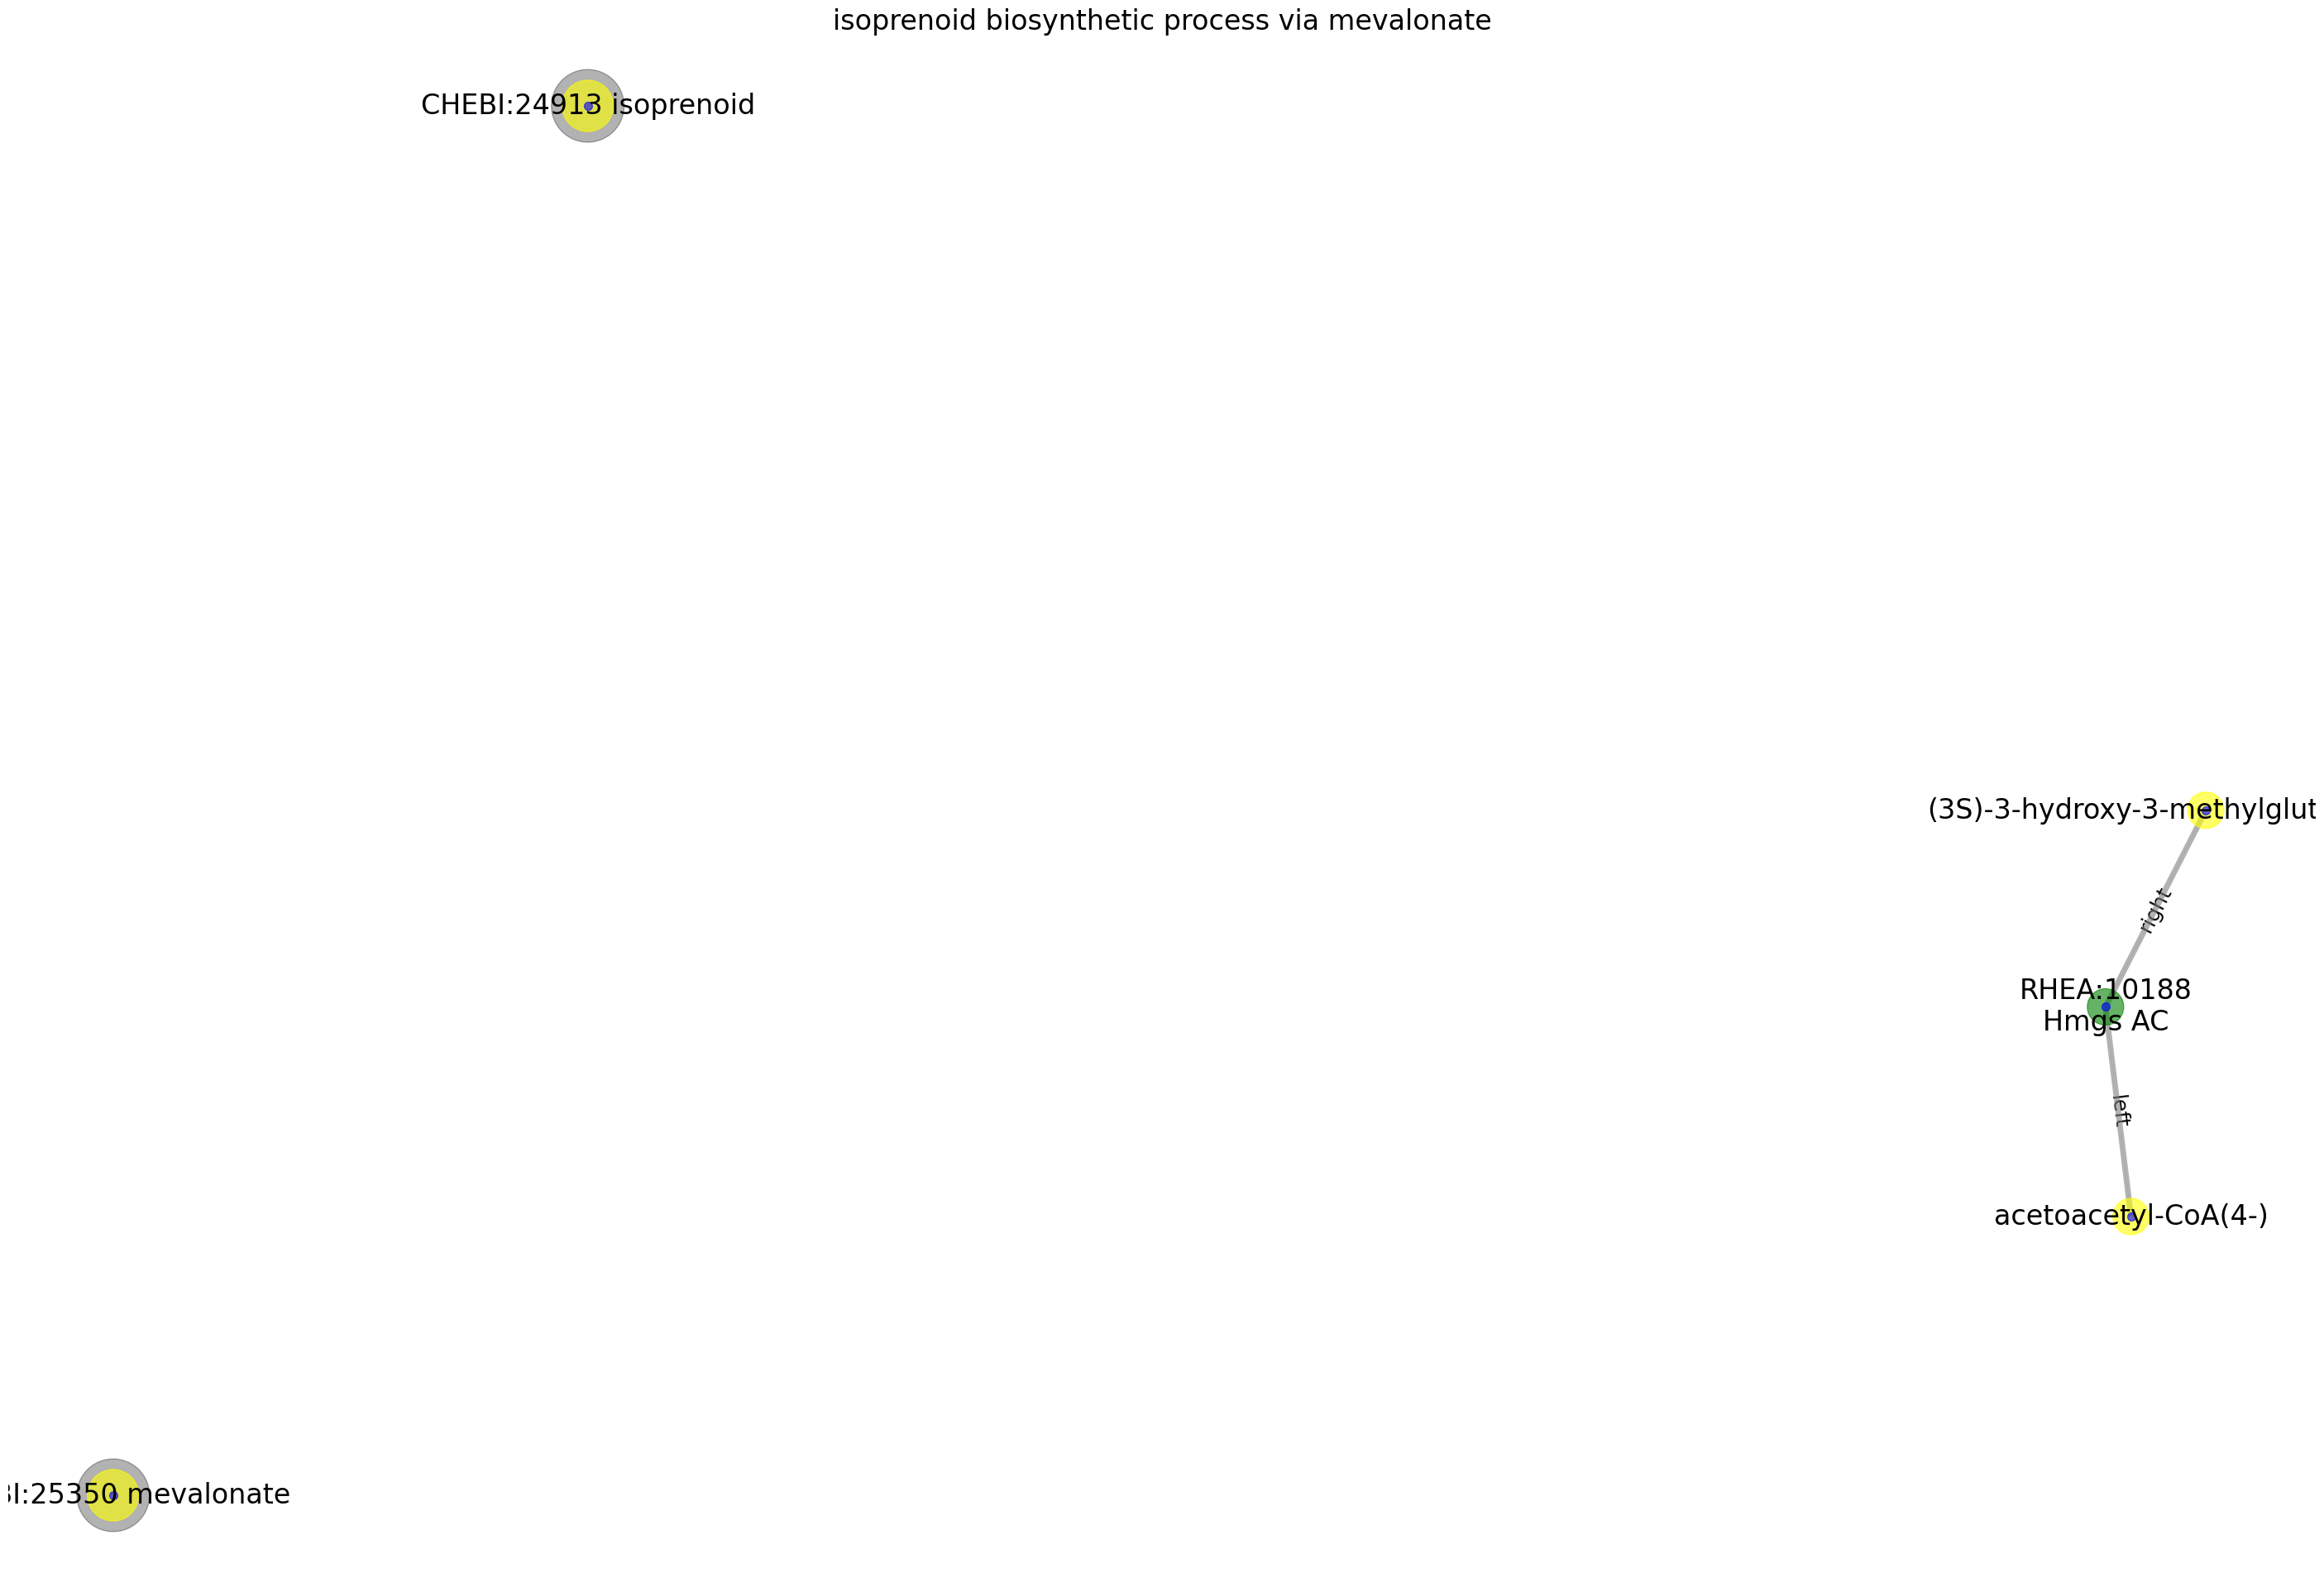

In [163]:
g = create_bipartite_graph_for_process_id(ISOP_VIA_MEV)
basic_plot(g)

In [164]:
g.graph

{'title': 'isoprenoid biosynthetic process via mevalonate',
 'number_of_connected_components': 3,
 'longest_path': 3,
 'number_of_reactions': 1,
 'number_of_chemicals': 2,
 'target_chemicals': {'CHEBI:24913', 'CHEBI:25350'},
 'target_chemical_labels': 'mevalonate, isoprenoid',
 'chebi_to_direction': {'CHEBI:24913': 'output',
  'CHEBI:25350': 'intermediate'},
 'processes': ['GO:1902767']}

In [165]:
g = create_bipartite_graph(example_annoton_df)
g.graph

1 subs of  GO:0006750


{'title': 'glutathione biosynthetic process',
 'number_of_connected_components': 1,
 'longest_path': 10,
 'number_of_reactions': 3,
 'number_of_chemicals': 7,
 'target_chemicals': {'CHEBI:57925'},
 'target_chemical_labels': 'glutathionate(1-)',
 'chebi_to_direction': {'CHEBI:57925': 'output'},
 'processes': ['GO:0006750']}


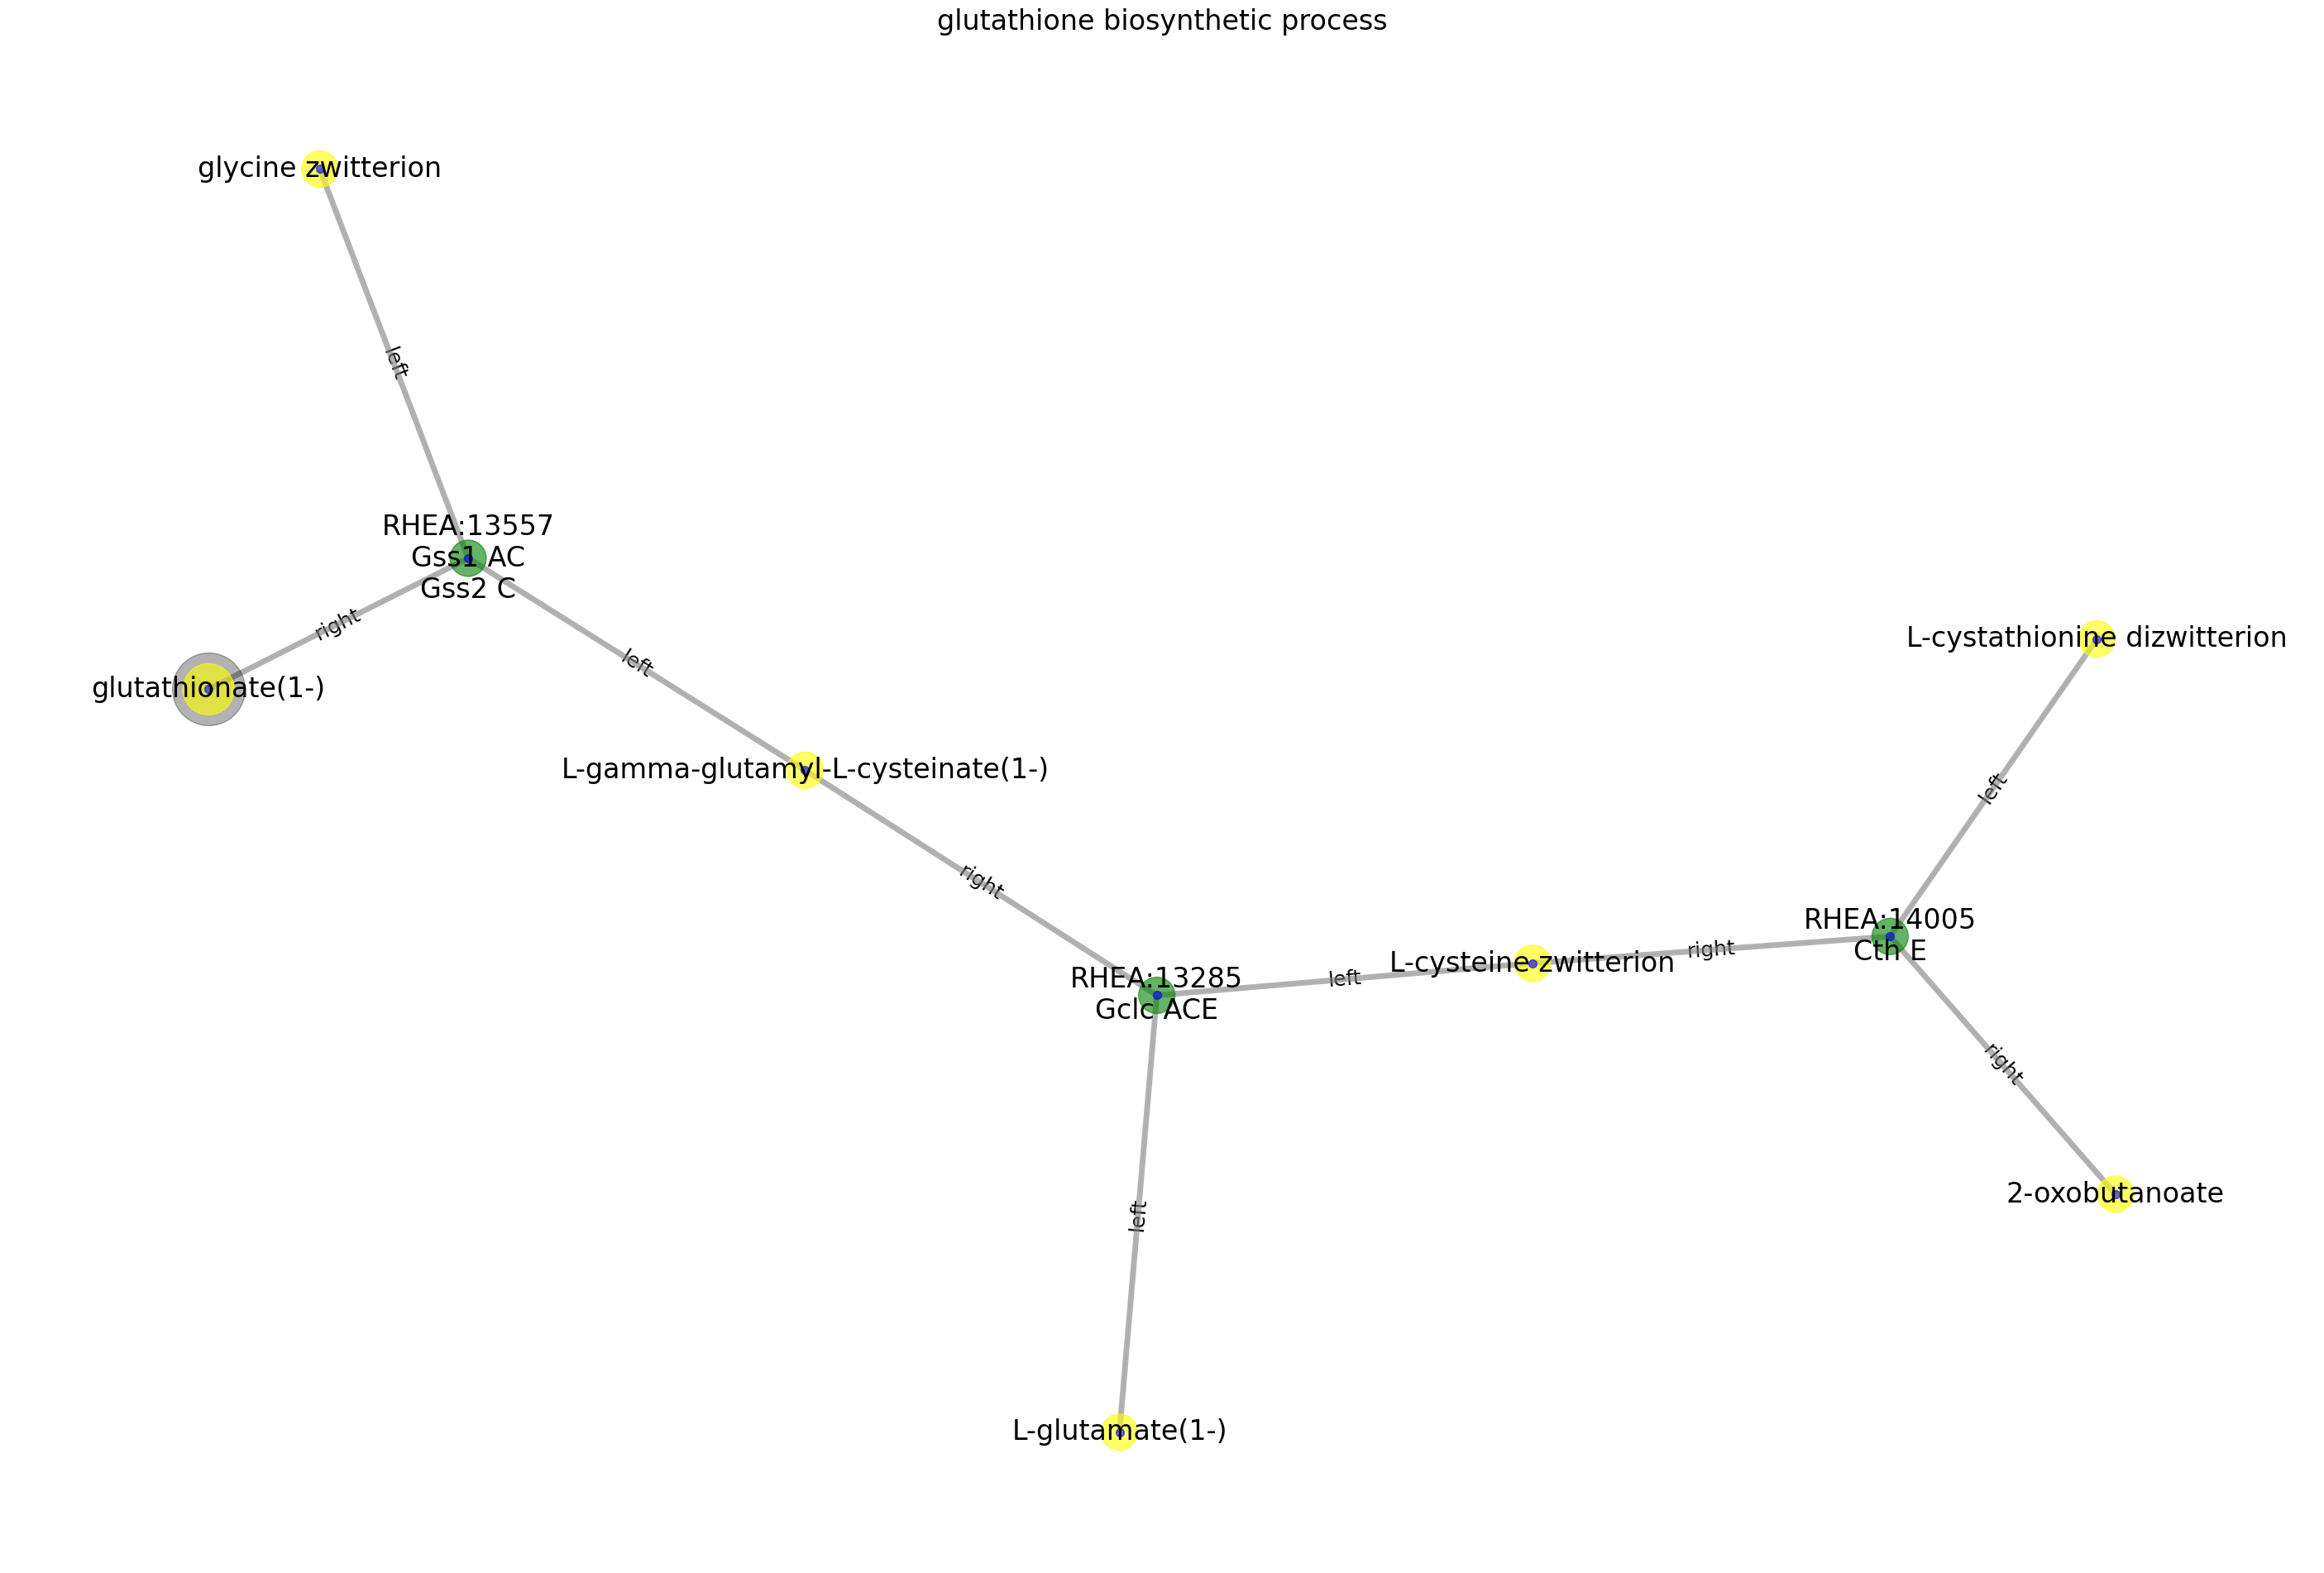

In [166]:
basic_plot(g)

In [167]:
def clean_graph(G: nx.Graph):
    # Clean node attributes
    for node, data in G.nodes(data=True):
        for key, value in list(data.items()):  # Use list to avoid RuntimeError during iteration
            if not isinstance(value, (int, float, str, bool)):
                print(f"FIXING {node} {key} {value}")
                data[key] = str(value)  # Convert unsupported types to strings
            del data[key]
            data[str(key)] = str(value)
    
    # Clean edge attributes
    for u, v, data in G.edges(data=True):
        for key, value in list(data.items()):
            if not isinstance(value, (int, float, str, bool)):
                print(f"FIXING {u} {v} {key} {value}")
                data[key] = str(value)  # Convert unsupported types to strings
            del data[key]
            data[str(key)] = str(value)

In [168]:
#assert False

## Create main outputs for all valid processes

In [169]:
graphs = {}
with open(f"{OUTDIR}/index.md", "w") as f:
    for root in [BIOSYNTHESIS, CATABOLISM]:
        for p in go_adapter.descendants([root], predicates=[IS_A]):
            if p in ["GO:0001015"]:
                # TODO
                continue
            p_name = go_adapter.label(p).replace(" ", "_").replace("/", "_")
            num_descendants = len(list(go_adapter.descendants([p], predicates=[IS_A])))
            if num_descendants > 10:
                print(f"Skipping {p} {p_name} with {num_descendants} descendants")
                continue
            print(f"PROCESS {p} {p_name}")
            annoton_df = make_annotons(p)
            print(f"ANNOTON {len(annoton_df)}")
            print(annoton_df)
            # if no annotations continue
            if len(annoton_df) == 0:
                print(f"Skipping {p} {p_name} with no annotations")
                continue
            g = create_bipartite_graph(annoton_df)
            graphs[p] = g
            basic_plot(g, filename=p_name)
            # clean_graph(g)
            # nx.write_graphml(g, f"output/{p_name}.graphml")
            f.write(f"\n\n## {p_name} ({p})\n\n")
            #f.write(f"![{p_name}]({p_name}.png)\n\n")
            f.write(f'<img width="1200" height="800" src="{p_name}.png">\n\n')
            for k, v in g.graph.items():
                f.write(f"* {k}: {v}\n")
            f.flush()
            

Skipping GO:0009058 biosynthetic_process with 1693 descendants
PROCESS GO:1900727 osmoregulated_periplasmic_glucan_biosynthetic_process
1 subs of  GO:1900727
ANNOTON 0
Empty DataFrame
Columns: []
Index: []
Skipping GO:1900727 osmoregulated_periplasmic_glucan_biosynthetic_process with no annotations
PROCESS GO:0019285 glycine_betaine_biosynthetic_process_from_choline
1 subs of  GO:0019285
ANNOTON 0
Empty DataFrame
Columns: []
Index: []
Skipping GO:0019285 glycine_betaine_biosynthetic_process_from_choline with no annotations
Skipping GO:0006633 fatty_acid_biosynthetic_process with 39 descendants
PROCESS GO:0051792 medium-chain_fatty_acid_biosynthetic_process
1 subs of  GO:0051792
Genes 2
ANNOTON 4
             gene gene_label     process process_evidence    activity  \
0  FB:FBgn0014906      Hydr2  GO:0051792           (IBA,)  GO:0047372   
1  FB:FBgn0014906      Hydr2  GO:0051792           (IBA,)  GO:0008126   
2  FB:FBgn0033382      Hydr1  GO:0051792           (IBA,)  GO:0008126   
3  


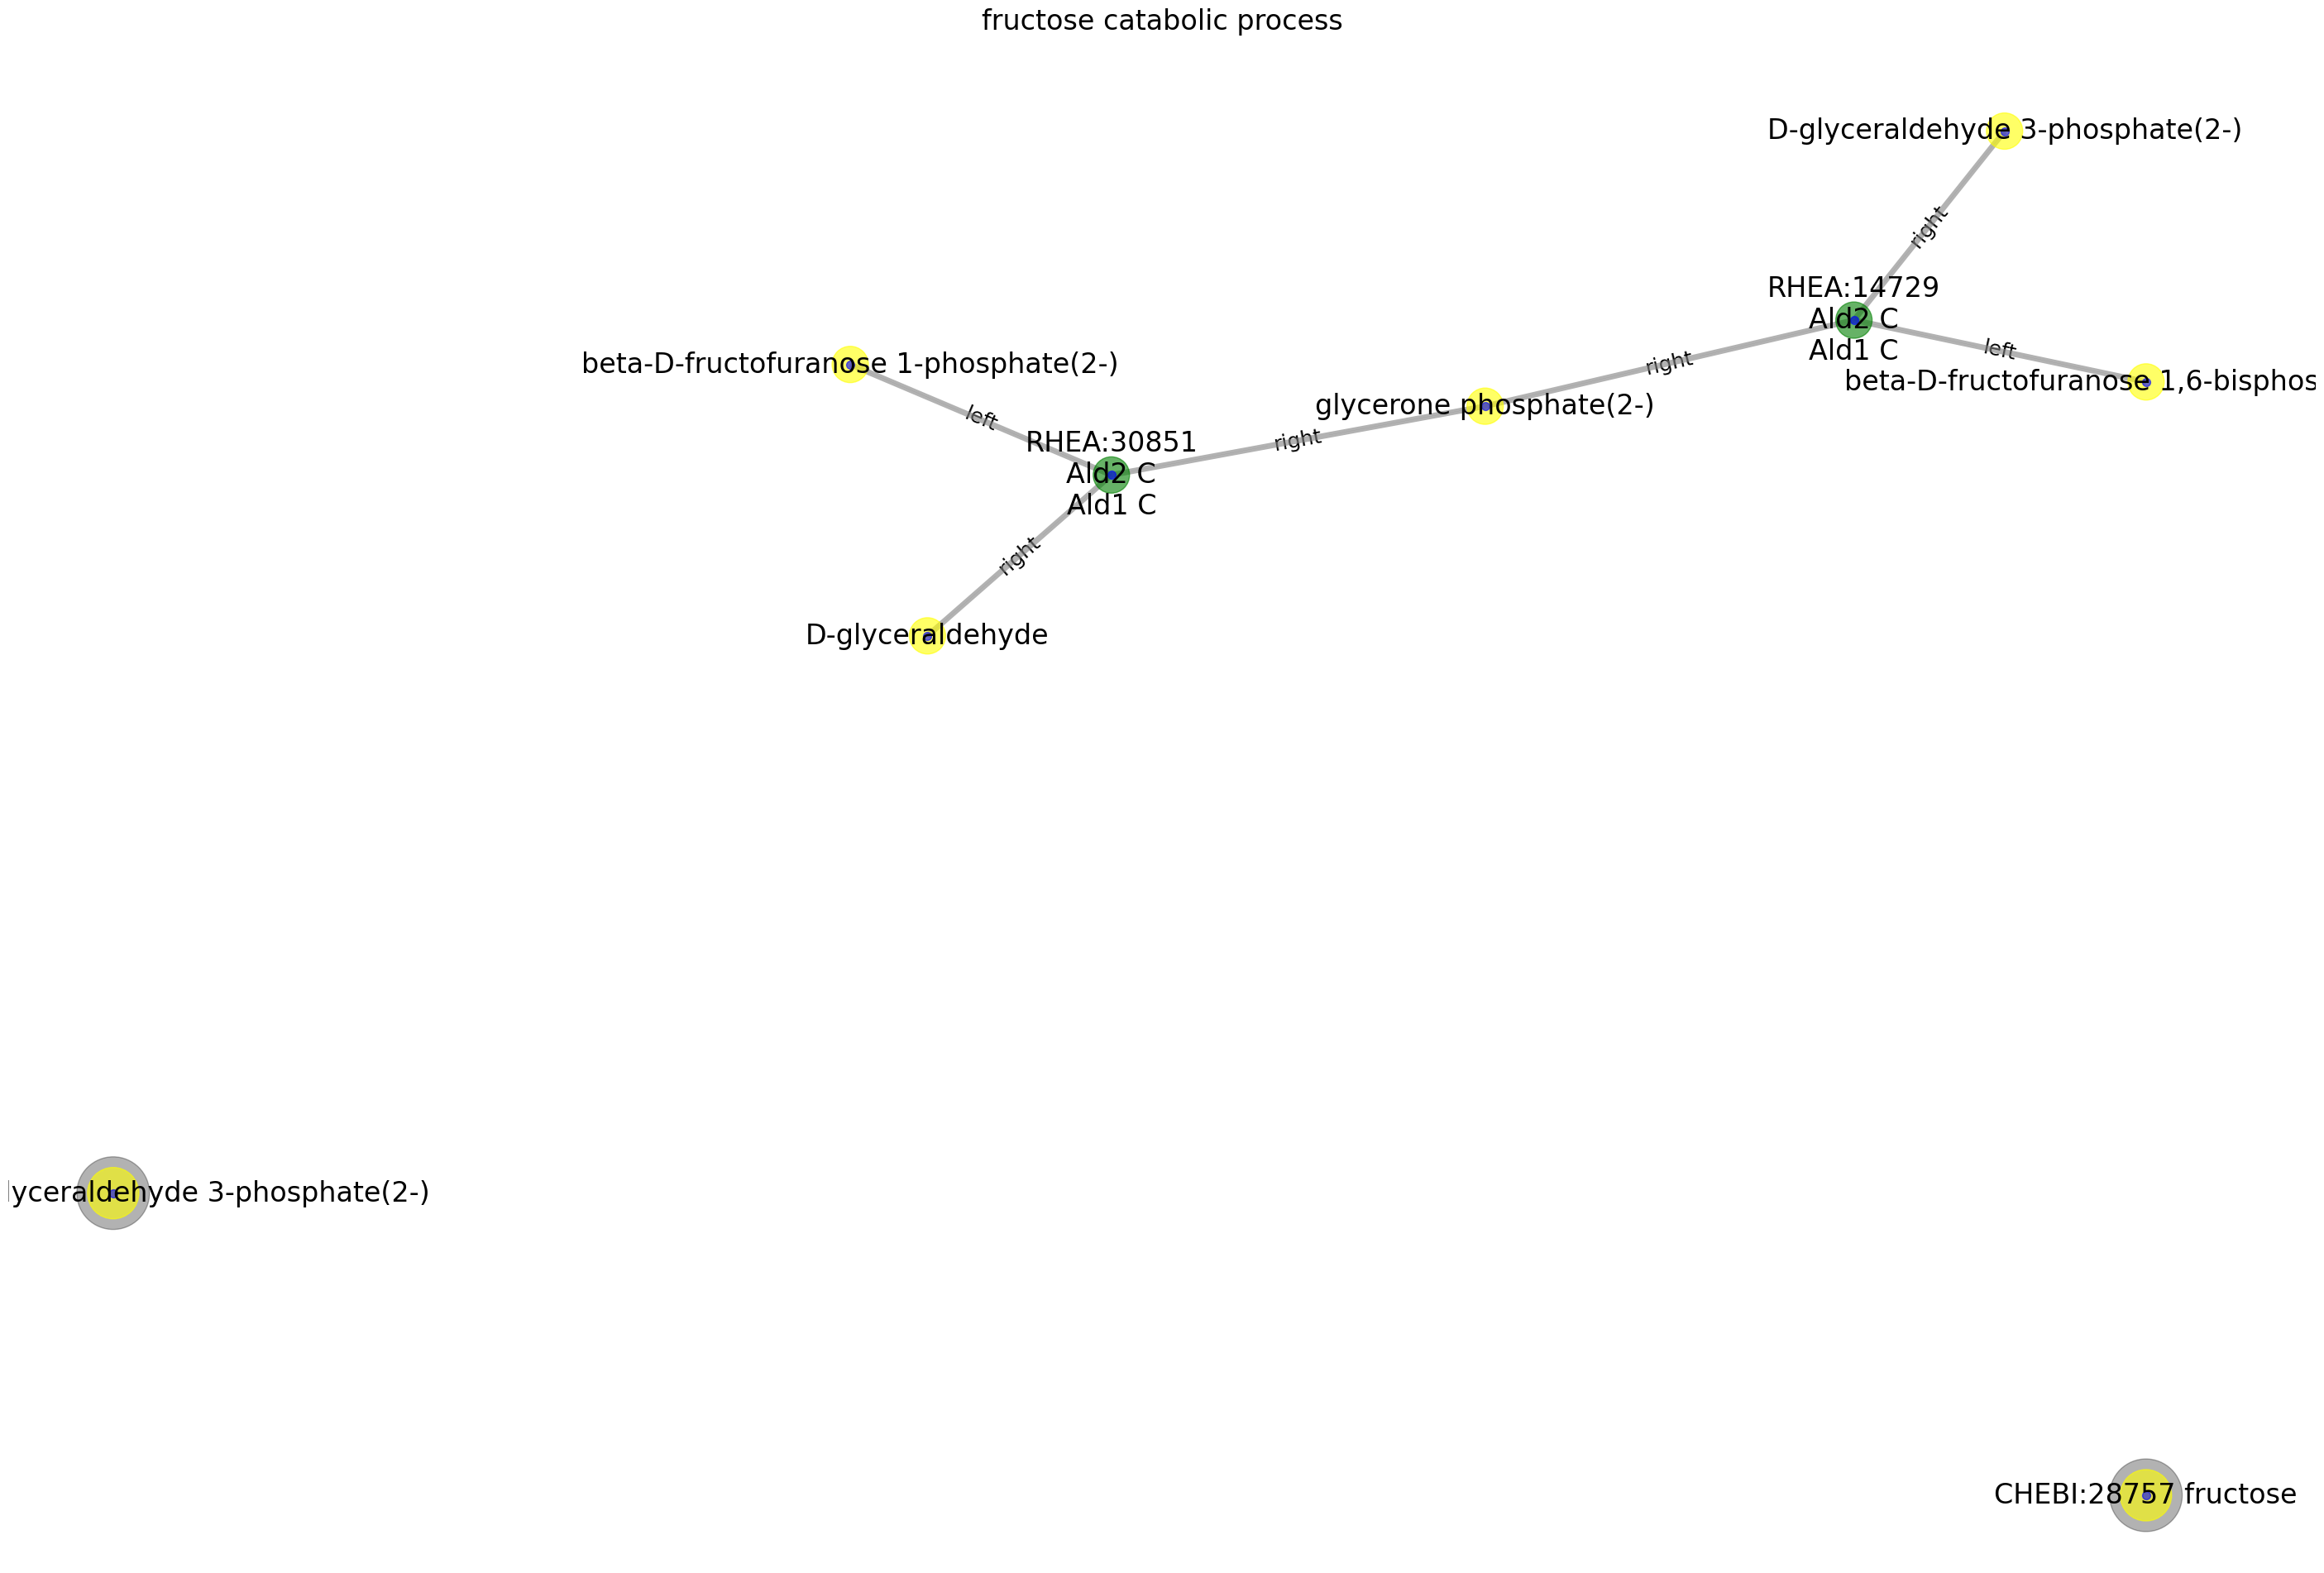

In [170]:
basic_plot(g)

In [171]:
def print_graph(G: nx.Graph):
    def lbl(n):
        return G.nodes[n].get("label", "").replace("\n", " ")
    for i, cc in enumerate(nx.connected_components(G)):
        print(f"# Component {i}")
        # we will do depth-first traversal through G, to ensure ordering of edges
        for node in nx.dfs_preorder_nodes(G, source=list(cc)[0]):
            node_label = lbl(node)
            print(f" * Node {node} :: {node_label}")
            for nbr in G.neighbors(node):
                nbr_label = lbl(nbr)
                if not nbr_label:
                    continue
                print(f"  -> {nbr}: {G.edges[node, nbr]['label']} :: {nbr_label}")
                

        

In [172]:
print_graph(g)

# Component 0
 * Node CHEBI:17378 :: D-glyceraldehyde
  -> RHEA:30851: right :: RHEA:30851 Ald2 C Ald1 C
 * Node RHEA:30851 :: RHEA:30851 Ald2 C Ald1 C
  -> CHEBI:138881: left :: beta-D-fructofuranose 1-phosphate(2-)
  -> CHEBI:17378: right :: D-glyceraldehyde
  -> CHEBI:57642: right :: glycerone phosphate(2-)
 * Node CHEBI:138881 :: beta-D-fructofuranose 1-phosphate(2-)
  -> RHEA:30851: left :: RHEA:30851 Ald2 C Ald1 C
 * Node CHEBI:57642 :: glycerone phosphate(2-)
  -> RHEA:14729: right :: RHEA:14729 Ald2 C Ald1 C
  -> RHEA:30851: right :: RHEA:30851 Ald2 C Ald1 C
 * Node RHEA:14729 :: RHEA:14729 Ald2 C Ald1 C
  -> CHEBI:32966: left :: beta-D-fructofuranose 1,6-bisphosphate(4-)
  -> CHEBI:57642: right :: glycerone phosphate(2-)
  -> CHEBI:59776: right :: D-glyceraldehyde 3-phosphate(2-)
 * Node CHEBI:32966 :: beta-D-fructofuranose 1,6-bisphosphate(4-)
  -> RHEA:14729: left :: RHEA:14729 Ald2 C Ald1 C
 * Node CHEBI:59776 :: D-glyceraldehyde 3-phosphate(2-)
  -> RHEA:14729: right :: RH

In [173]:
nx.number_connected_components(g)

3

In [174]:
g.edges

EdgeView([('CHEBI:32966', 'RHEA:14729'), ('RHEA:14729', 'CHEBI:57642'), ('RHEA:14729', 'CHEBI:59776'), ('CHEBI:57642', 'RHEA:30851'), ('CHEBI:138881', 'RHEA:30851'), ('RHEA:30851', 'CHEBI:17378')])

In [175]:
def create_process_graph(process: str) -> nx.Graph:
    annoton_df = make_annotons(process)
    return create_graph_from_annoton_df(annoton_df)

In [176]:
ASP_FAM_SYN = "GO:0009067"

In [177]:
asp_g = create_process_graph(ASP_FAM_SYN)

30 subs of  GO:0009067
Genes 15


NameError: name 'create_graph_from_annoton_df' is not defined


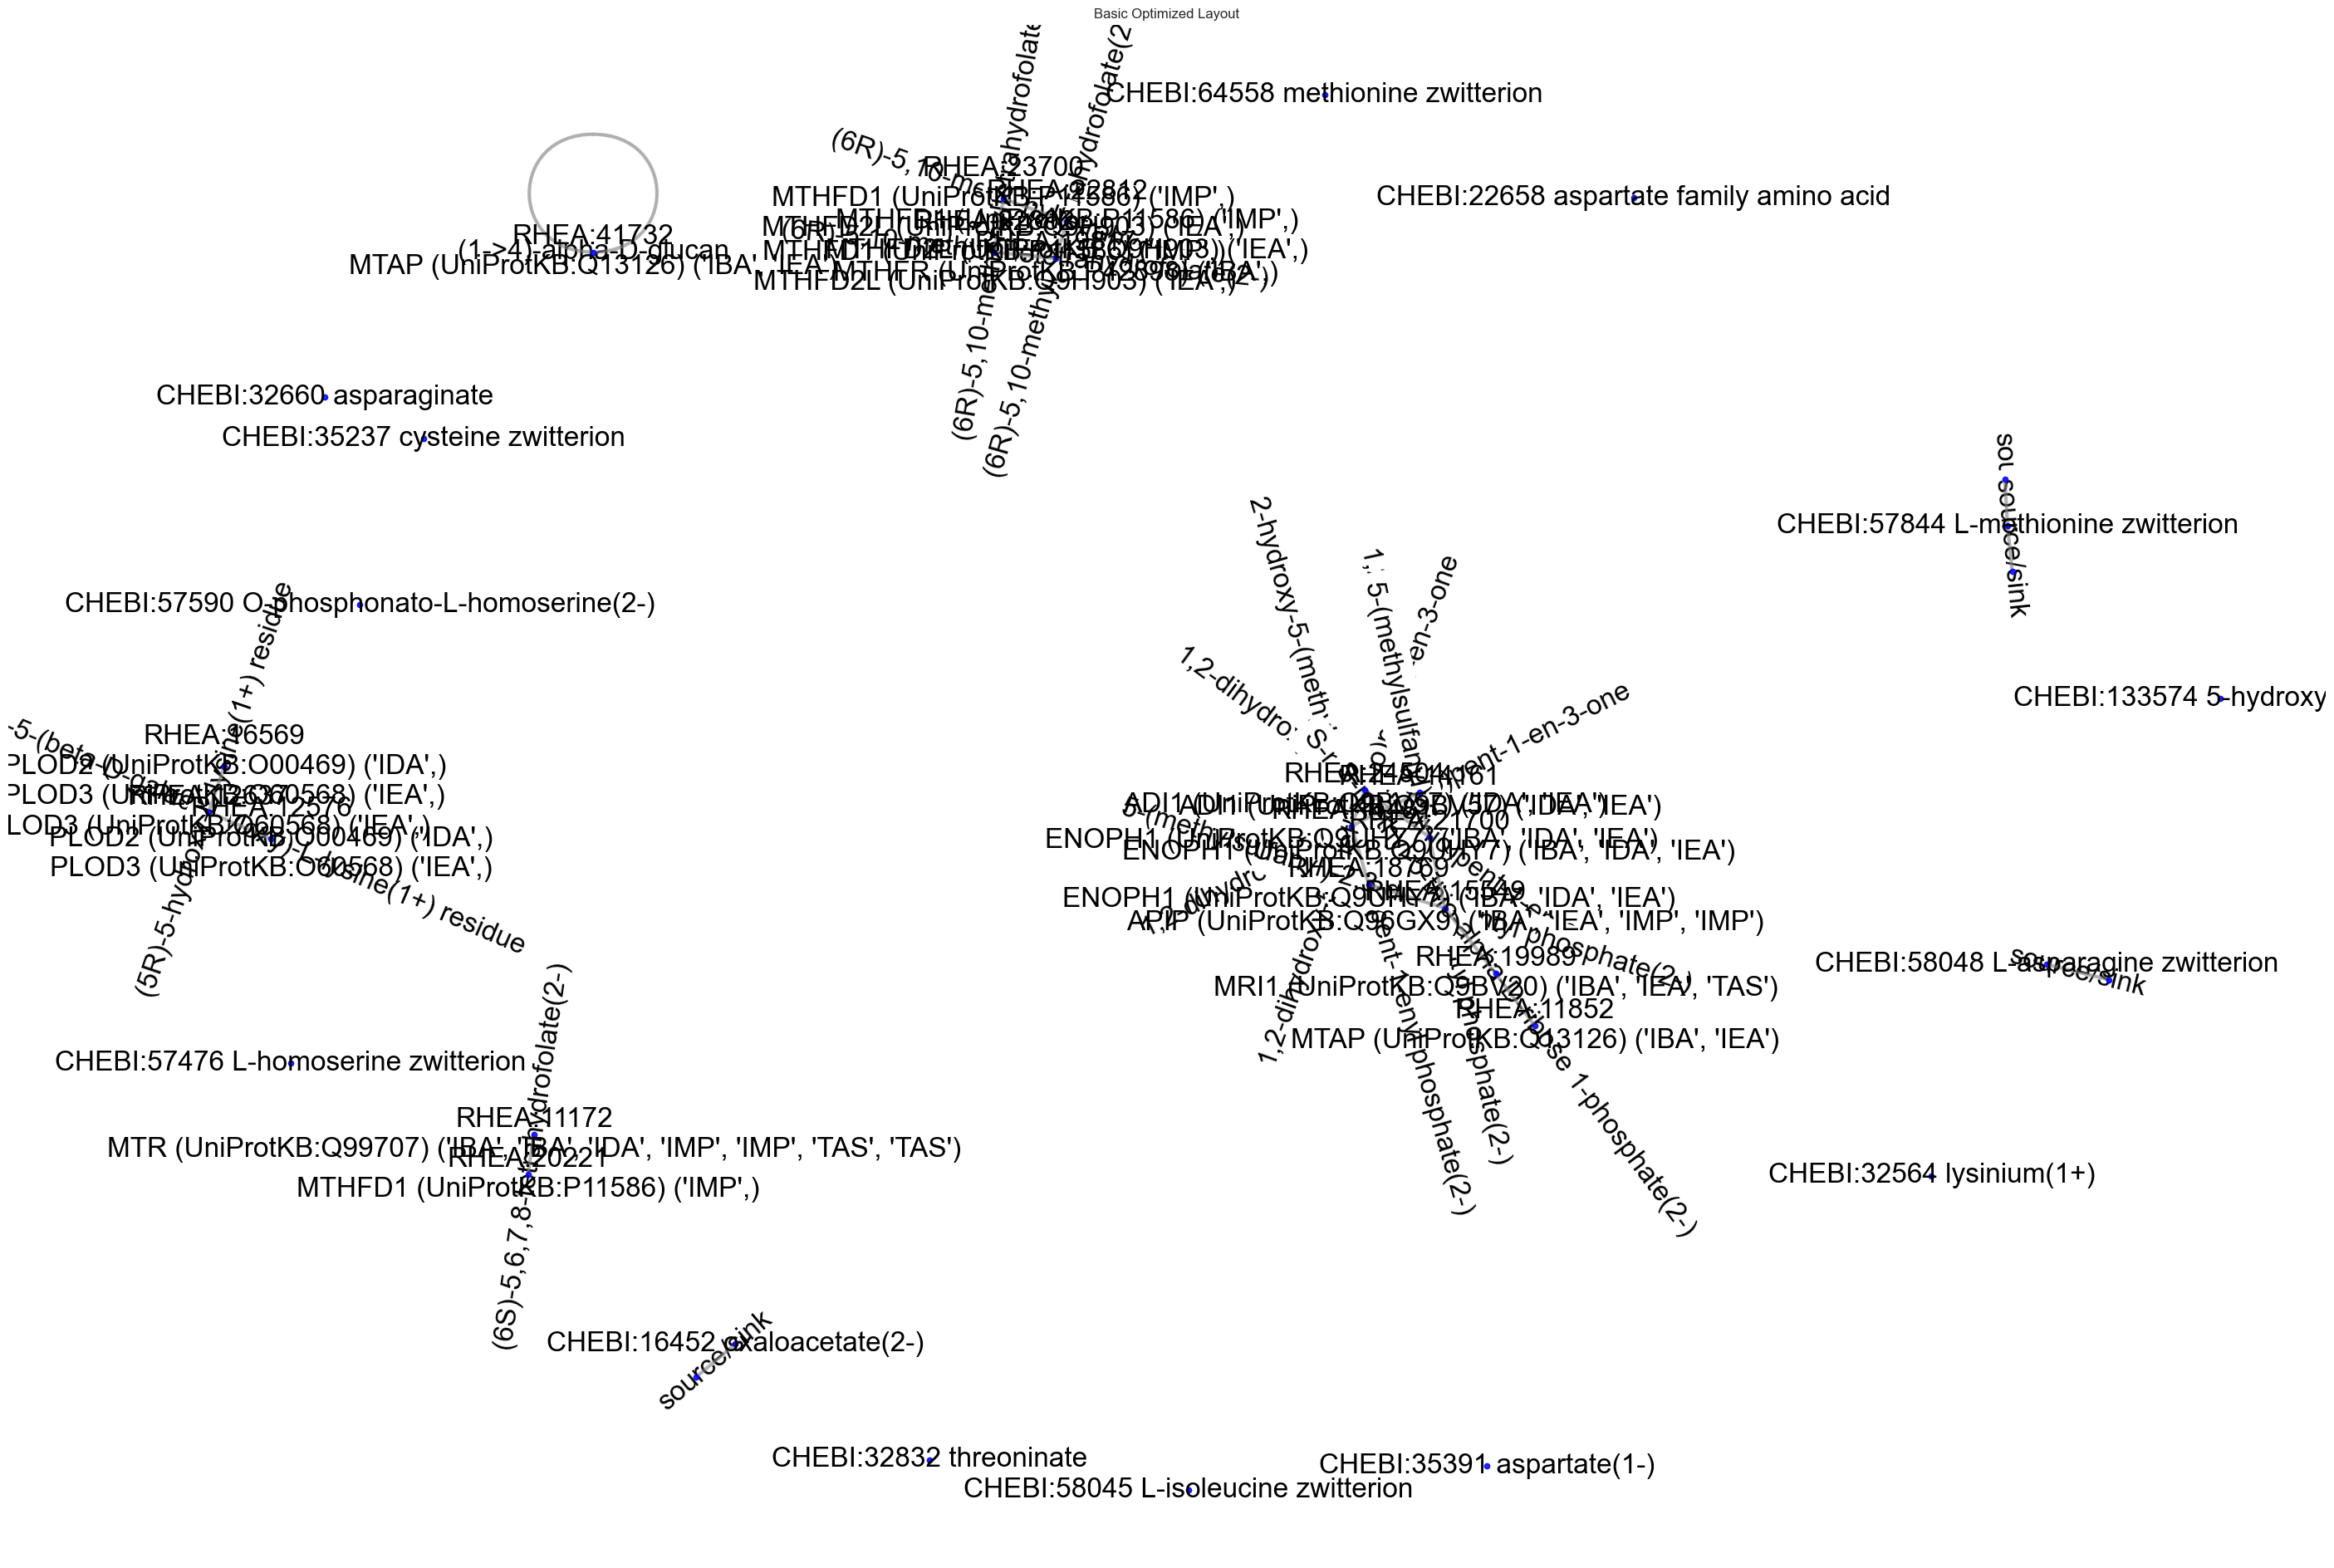

In [191]:
basic_plot(asp_g)

In [192]:
clean_graph(asp_g)

FIXING RHEA:12576 RHEA:12637 process_evidence_left ('IEA',)
FIXING RHEA:12576 RHEA:12637 primary_input_left [None, 'CHEBI:16452', 'CHEBI:35237', 'CHEBI:57476', 'CHEBI:57590']
FIXING RHEA:12576 RHEA:12637 primary_output_left ['CHEBI:32660', 'CHEBI:35391', 'CHEBI:22658', 'CHEBI:32564', 'CHEBI:64558', 'CHEBI:32832', None, 'CHEBI:133574', 'CHEBI:58048', 'CHEBI:57844', 'CHEBI:58045']
FIXING RHEA:12576 RHEA:12637 process_evidence_right ('IEA',)
FIXING RHEA:12576 RHEA:12637 primary_input_right [None, 'CHEBI:16452', 'CHEBI:35237', 'CHEBI:57476', 'CHEBI:57590']
FIXING RHEA:12576 RHEA:12637 primary_output_right ['CHEBI:32660', 'CHEBI:35391', 'CHEBI:22658', 'CHEBI:32564', 'CHEBI:64558', 'CHEBI:32832', None, 'CHEBI:133574', 'CHEBI:58048', 'CHEBI:57844', 'CHEBI:58045']
FIXING RHEA:12637 RHEA:16569 process_evidence_left ('IEA',)
FIXING RHEA:12637 RHEA:16569 primary_input_left [None, 'CHEBI:16452', 'CHEBI:35237', 'CHEBI:57476', 'CHEBI:57590']
FIXING RHEA:12637 RHEA:16569 primary_output_left ['CHEBI:3

In [187]:
!mkdir -p output

In [193]:

nx.write_graphml(asp_g, f"output/aspartate-family.graphml")

In [194]:
ASPG_SYN = "GO:0070981"

In [195]:
aspg_g = create_process_graph(ASPG_SYN)


1 subs of  GO:0070981
1 subs of  GO:0070981
CHEBIs input [None] for GO:0070981
CHEBIs output ['CHEBI:58048'] for GO:0070981



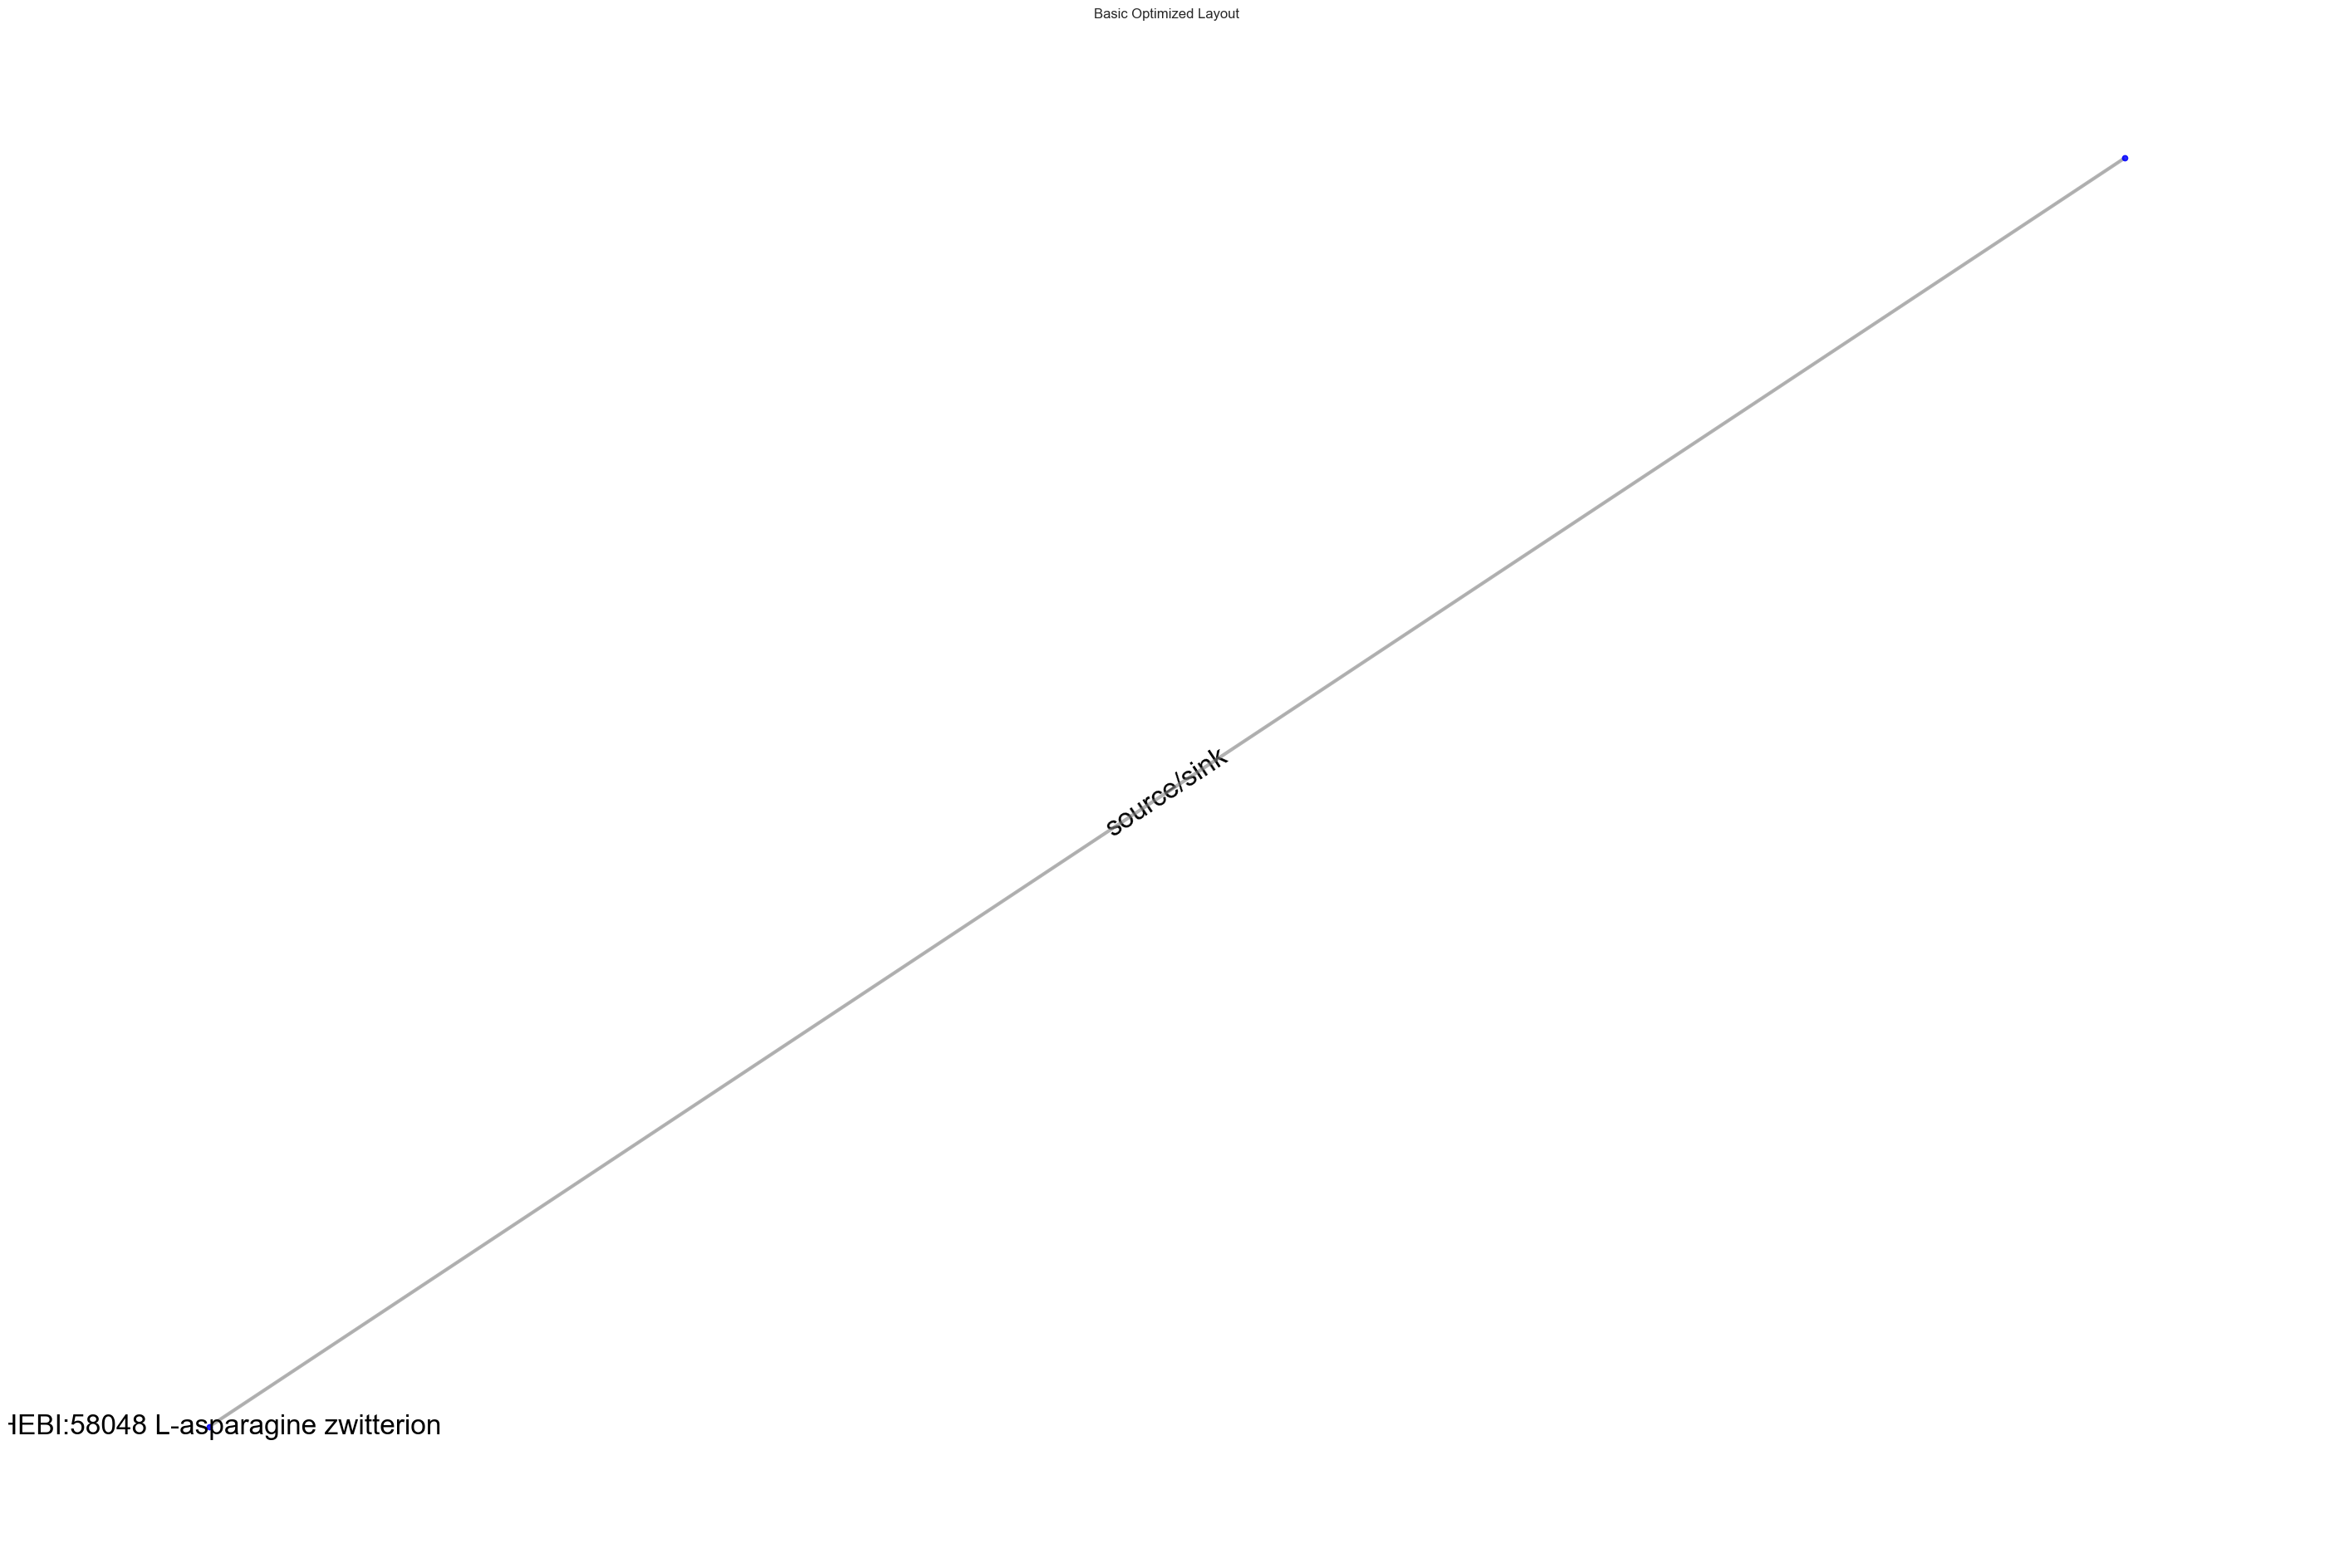

In [196]:
basic_plot(aspg_g)